# **About Dataset**
This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

# **Importing libraries**

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

from nltk.stem import SnowballStemmer
from nltk import TweetTokenizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

# **Reading the Dataset**

In [83]:
df_col=['Id','Location','Target','Text']
df=pd.read_csv('/content/drive/MyDrive/dataset/twitter_validation.csv',names=df_col)
df

Id             Location      Target  \
0    3364             Facebook  Irrelevant   
1     352               Amazon     Neutral   
2    8312            Microsoft    Negative   
3    4371                CS-GO    Negative   
4    4433               Google     Neutral   
..    ...                  ...         ...   
995  4891  GrandTheftAuto(GTA)  Irrelevant   
996  4359                CS-GO  Irrelevant   
997  2652          Borderlands    Positive   
998  8069            Microsoft    Positive   
999  6960      johnson&johnson     Neutral   

                                                  Text  
0    I mentioned on Facebook that I was struggling ...  
1    BBC News - Amazon boss Jeff Bezos rejects clai...  
2    @Microsoft Why do I pay for WORD when it funct...  
3    CSGO matchmaking is so full of closet hacking,...  
4    Now the President is slapping Americans in the...  
..                                                 ...  
995  ⭐️ Toronto is the arts and culture capital of ...  
996  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...  
997  Today sucked so it’s time to drink wine n play...  
998  Bought a fraction of Microsoft today. Small wins.  
999  Johnson & Johnson to stop selling talc baby po...  

[1000 rows x 4 columns]

In [84]:
df.columns

Index(['Id', 'Location', 'Target', 'Text'], dtype='object')

In [85]:
df.dtypes

Id           int64
Location    object
Target      object
Text        object
dtype: object

# **Checking the missing values**

In [86]:
df.isna().sum()

Id          0
Location    0
Target      0
Text        0
dtype: int64

**Checking Duplicated values**

In [87]:
df.duplicated().sum()

0

# **Data Visualization**

<Axes: xlabel='Target', ylabel='count'>

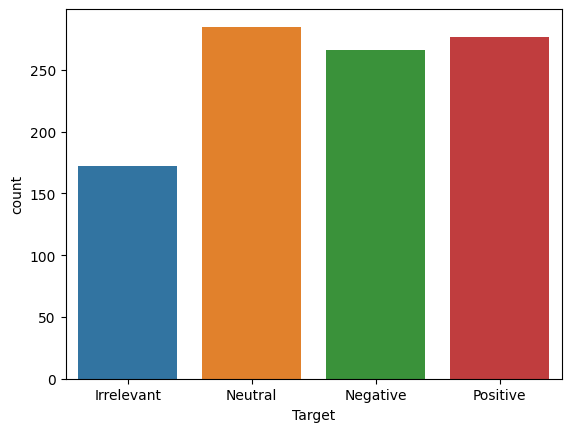

In [88]:

sns.countplot(x='Target',data=df)

<Axes: title={'center': 'Number for each game in Twitter dataset'}>

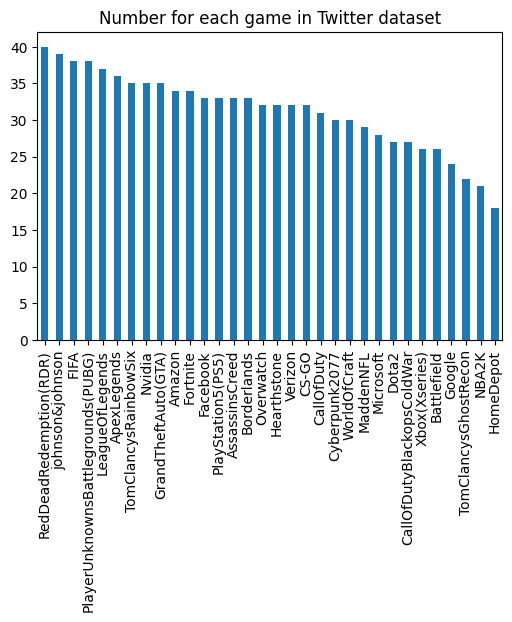

In [89]:
df["Location"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each game in Twitter dataset")

# **Dropping Irrelvant**

In [90]:
df.drop(df.index[(df['Target']=='Irrelevant')],axis=0,inplace=True)

In [91]:
df['Target'].value_counts()

Neutral     285
Positive    277
Negative    266
Name: Target, dtype: int64

In [92]:
df.reset_index(drop=True,inplace=True)

In [93]:
df

Id           Location    Target  \
0     352             Amazon   Neutral   
1    8312          Microsoft  Negative   
2    4371              CS-GO  Negative   
3    4433             Google   Neutral   
4    6273               FIFA  Negative   
..    ...                ...       ...   
823   314             Amazon  Negative   
824  9701  PlayStation5(PS5)  Positive   
825  2652        Borderlands  Positive   
826  8069          Microsoft  Positive   
827  6960    johnson&johnson   Neutral   

                                                  Text  
0    BBC News - Amazon boss Jeff Bezos rejects clai...  
1    @Microsoft Why do I pay for WORD when it funct...  
2    CSGO matchmaking is so full of closet hacking,...  
3    Now the President is slapping Americans in the...  
4    Hi @EAHelp I’ve had Madeleine McCann in my cel...  
..                                                 ...  
823  Please explain how this is possible! How can t...  
824  Good on Sony. As much as I want to see the new...  
825  Today sucked so it’s time to drink wine n play...  
826  Bought a fraction of Microsoft today. Small wins.  
827  Johnson & Johnson to stop selling talc baby po...  

[828 rows x 4 columns]

In [94]:
df.drop(['Id','Location'],axis=1,inplace=True)
df

Target                                               Text
0     Neutral  BBC News - Amazon boss Jeff Bezos rejects clai...
1    Negative  @Microsoft Why do I pay for WORD when it funct...
2    Negative  CSGO matchmaking is so full of closet hacking,...
3     Neutral  Now the President is slapping Americans in the...
4    Negative  Hi @EAHelp I’ve had Madeleine McCann in my cel...
..        ...                                                ...
823  Negative  Please explain how this is possible! How can t...
824  Positive  Good on Sony. As much as I want to see the new...
825  Positive  Today sucked so it’s time to drink wine n play...
826  Positive  Bought a fraction of Microsoft today. Small wins.
827   Neutral  Johnson & Johnson to stop selling talc baby po...

[828 rows x 2 columns]

In [95]:
df['Target']=df['Target'].map({'Positive':1,'Negative':-1,'Neutral':0})

In [96]:
df

Target                                               Text
0         0  BBC News - Amazon boss Jeff Bezos rejects clai...
1        -1  @Microsoft Why do I pay for WORD when it funct...
2        -1  CSGO matchmaking is so full of closet hacking,...
3         0  Now the President is slapping Americans in the...
4        -1  Hi @EAHelp I’ve had Madeleine McCann in my cel...
..      ...                                                ...
823      -1  Please explain how this is possible! How can t...
824       1  Good on Sony. As much as I want to see the new...
825       1  Today sucked so it’s time to drink wine n play...
826       1  Bought a fraction of Microsoft today. Small wins.
827       0  Johnson & Johnson to stop selling talc baby po...

[828 rows x 2 columns]

# **Preprocessing**

In [97]:
#Assign text columns to a new variable
tweets=df.Text
tweets

0      BBC News - Amazon boss Jeff Bezos rejects clai...
1      @Microsoft Why do I pay for WORD when it funct...
2      CSGO matchmaking is so full of closet hacking,...
3      Now the President is slapping Americans in the...
4      Hi @EAHelp I’ve had Madeleine McCann in my cel...
                             ...                        
823    Please explain how this is possible! How can t...
824    Good on Sony. As much as I want to see the new...
825    Today sucked so it’s time to drink wine n play...
826    Bought a fraction of Microsoft today. Small wins.
827    Johnson & Johnson to stop selling talc baby po...
Name: Text, Length: 828, dtype: object

In [98]:
#removing special characters 
tweets=tweets.str.replace('[^a-zA-Z0-9]+'," ")
tweets

<ipython-input-98-3b947e35decc>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets=tweets.str.replace('[^a-zA-Z0-9]+'," ")


0      BBC News Amazon boss Jeff Bezos rejects claims...
1       Microsoft Why do I pay for WORD when it funct...
2      CSGO matchmaking is so full of closet hacking ...
3      Now the President is slapping Americans in the...
4      Hi EAHelp I ve had Madeleine McCann in my cell...
                             ...                        
823    Please explain how this is possible How can th...
824    Good on Sony As much as I want to see the new ...
825    Today sucked so it s time to drink wine n play...
826     Bought a fraction of Microsoft today Small wins 
827    Johnson Johnson to stop selling talc baby powd...
Name: Text, Length: 828, dtype: object

**Stemming And Tokenization**

In [99]:
stemmer=SnowballStemmer('english')
tk=TweetTokenizer()

In [100]:
tweets=tweets.apply(lambda x:[stemmer.stem(i.lower()) for i in tk.tokenize(x)]).apply(lambda y:" ".join(y))
tweets

0      bbc news amazon boss jeff bezo reject claim co...
1      microsoft whi do i pay for word when it functi...
2      csgo matchmak is so full of closet hack it s a...
3      now the presid is slap american in the face th...
4      hi eahelp i ve had madelein mccann in my cella...
                             ...                        
823    pleas explain how this is possibl how can they...
824    good on soni as much as i want to see the new ...
825    today suck so it s time to drink wine n play b...
826       bought a fraction of microsoft today small win
827    johnson johnson to stop sell talc babi powder ...
Name: Text, Length: 828, dtype: object

**StopWords**

In [101]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw=stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
tweets=tweets.apply(lambda x:[i for i in tk.tokenize(x) if i not in sw]).apply(lambda y:" ".join(y))
tweets

0      bbc news amazon boss jeff bezo reject claim co...
1      microsoft whi pay word function poor samsungus...
2           csgo matchmak full closet hack truli aw game
3      presid slap american face realli commit unlaw ...
4      hi eahelp madelein mccann cellar past 13 year ...
                             ...                        
823    pleas explain possibl let compani overcharg sc...
824    good soni much want see new ps5 go right much ...
825    today suck time drink wine n play borderland s...
826            bought fraction microsoft today small win
827    johnson johnson stop sell talc babi powder u c...
Name: Text, Length: 828, dtype: object

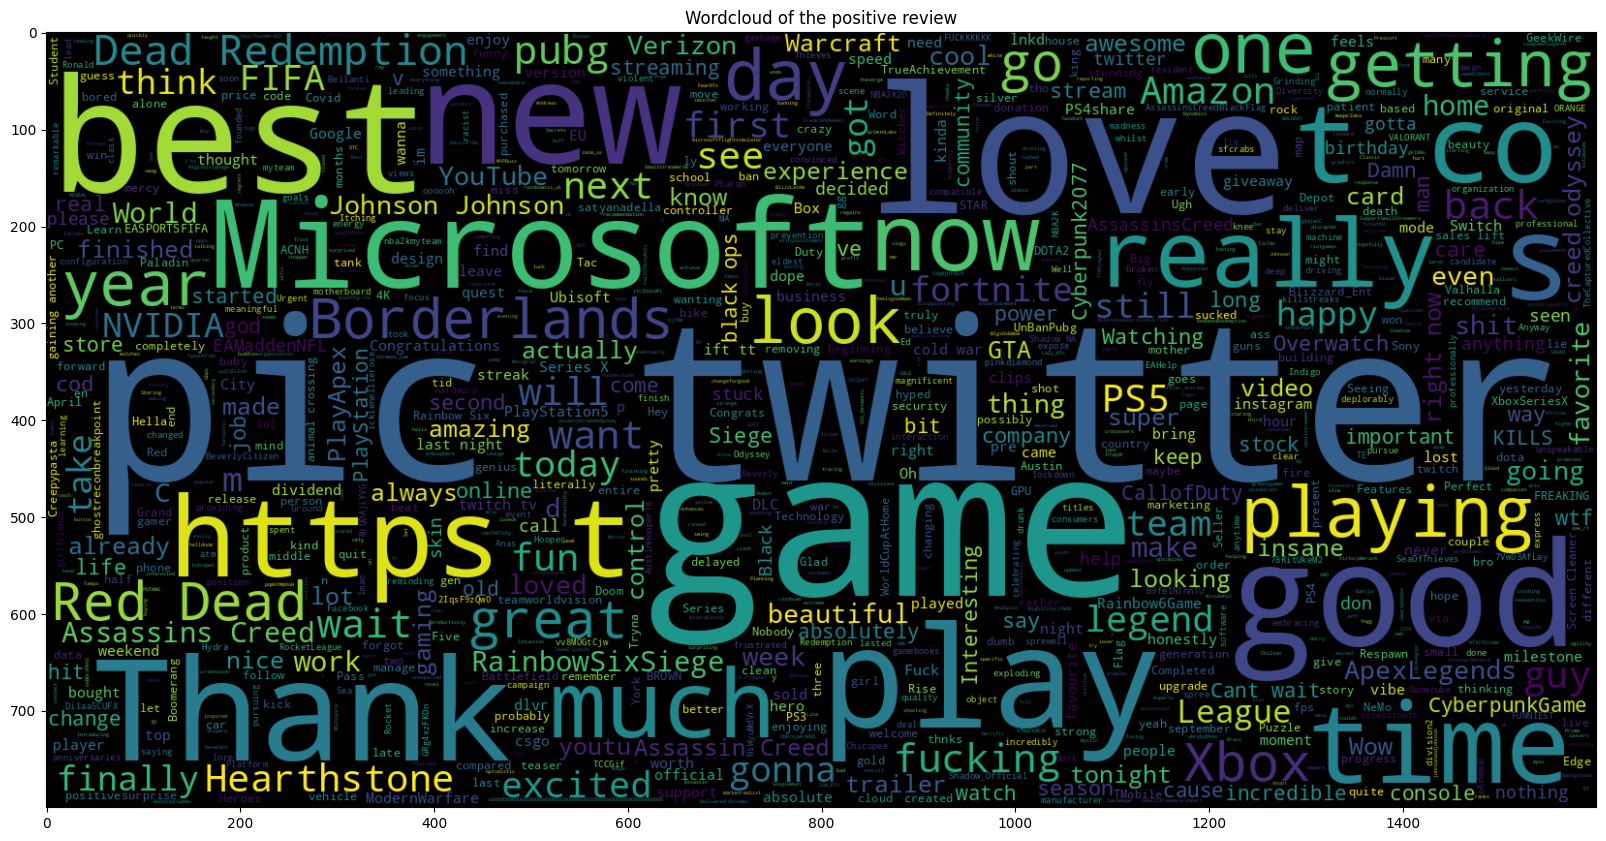

In [109]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(df[df["Target"] == 1]["Text"]))
plt.title("Wordcloud of the positive review")
plt.imshow(wc, interpolation = 'bilinear')

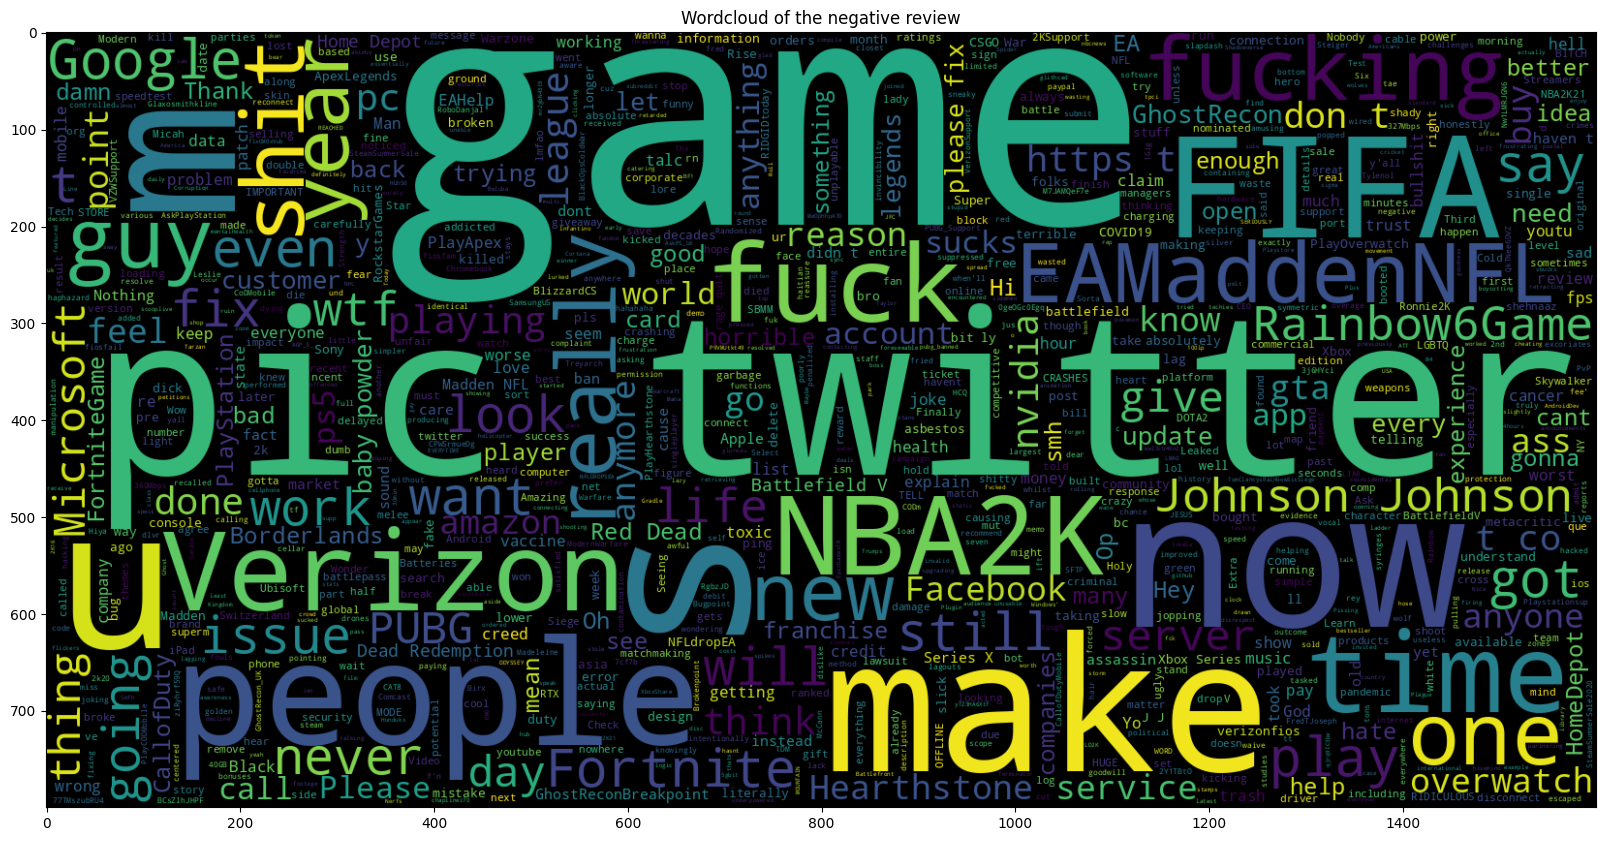

In [111]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(df[df["Target"] == -1]["Text"]))
plt.title("Wordcloud of the negative review")
plt.imshow(wc, interpolation = 'bilinear')

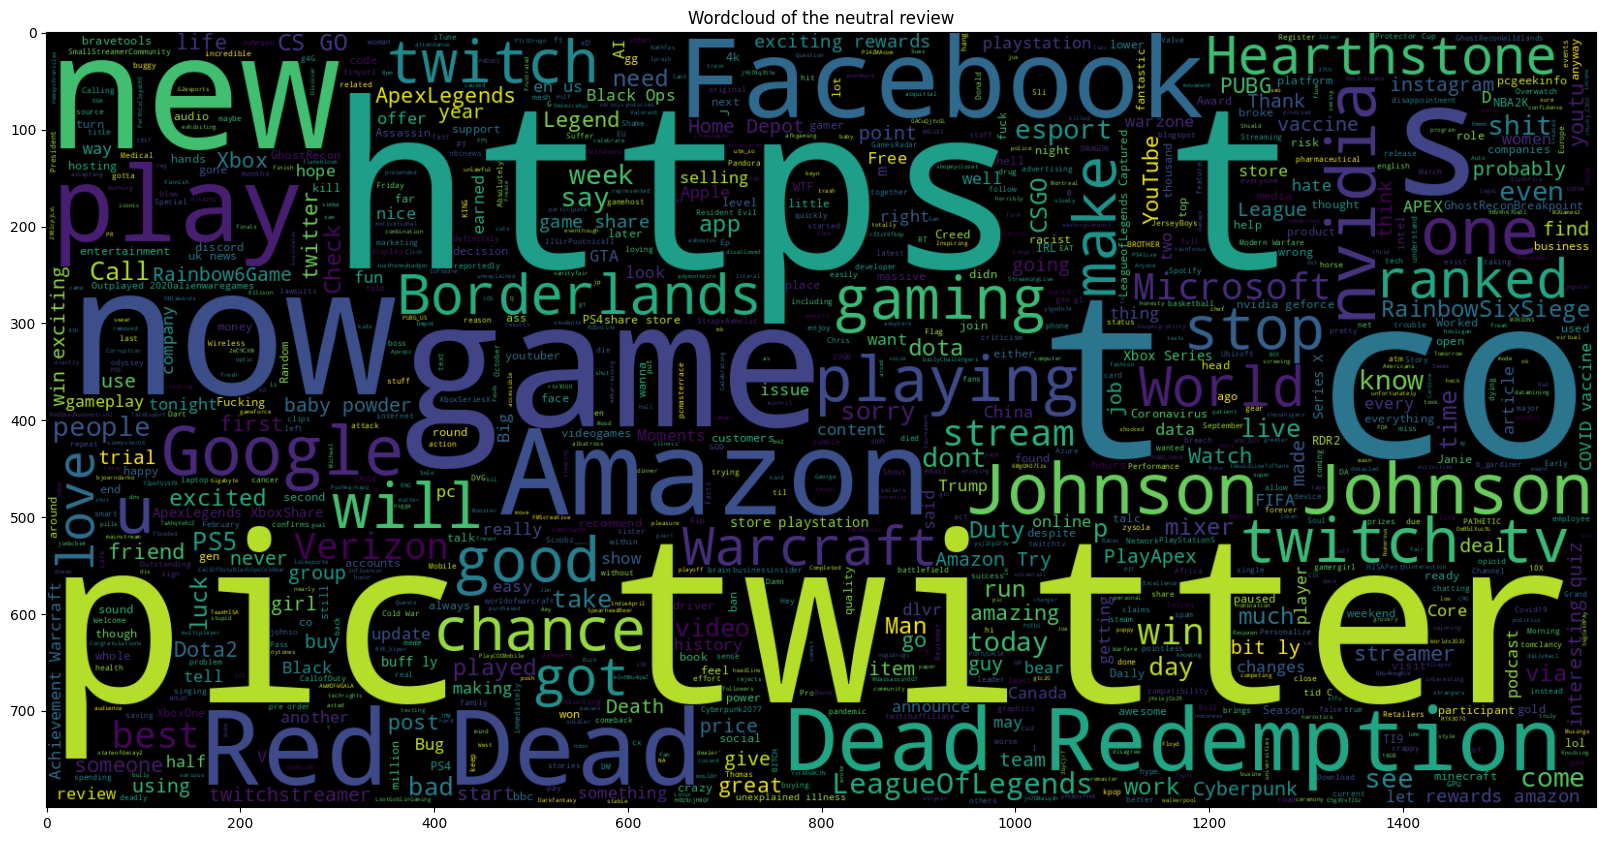

In [114]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(df[df["Target"] == 0]["Text"]))
plt.title("Wordcloud of the neutral review")
plt.imshow(wc, interpolation = 'bilinear')

**Vectorization**

In [103]:

vectorizer=TfidfVectorizer()
train_vec=vectorizer.fit_transform(tweets)
print(train_vec)

  (0, 739)	0.2456282916977699
  (0, 526)	0.2456282916977699
  (0, 3601)	0.19717097284763976
  (0, 883)	0.11802111433875656
  (0, 1060)	0.2456282916977699
  (0, 1189)	0.22139963227270484
  (0, 2091)	0.12503547156807654
  (0, 347)	0.2135997461023189
  (0, 912)	0.16343698819954885
  (0, 857)	0.2018385048310212
  (0, 2880)	0.2456282916977699
  (0, 612)	0.2456282916977699
  (0, 1919)	0.23145543449136263
  (0, 679)	0.2135997461023189
  (0, 417)	0.14270670271218175
  (0, 2392)	0.365996231282465
  (0, 581)	0.46291086898272527
  (1, 847)	0.4055823664694651
  (1, 3016)	0.4055823664694651
  (1, 2673)	0.3821800909185634
  (1, 1474)	0.4055823664694651
  (1, 3821)	0.36557591217188057
  (1, 2575)	0.3126902562590763
  (1, 3780)	0.26216072802580975
  (1, 2254)	0.24555654927912696
  :	:
  (825, 677)	0.22981061112100945
  (825, 1053)	0.2315686698425631
  (825, 3504)	0.21750175079084832
  (825, 3354)	0.2904718522758868
  (825, 2641)	0.17148706662740873
  (826, 1449)	0.5079831062080814
  (826, 3197)	0.4786

In [104]:
print(train_vec.shape)

(828, 3931)


In [105]:
X=train_vec
y=df['Target'].values

In [106]:
#Splitting datas into training and test dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [107]:
#Classification Model Creation
sv=SVC()
mn=MultinomialNB()
rf=RandomForestClassifier()
ab=AdaBoostClassifier()
lst=[sv,mn,rf,ab]

SVC()
****************************Prediction for new string*************************** *******Negative***************
              precision    recall  f1-score   support

          -1       0.60      0.72      0.65        74
           0       0.64      0.65      0.64        91
           1       0.67      0.55      0.60        84

    accuracy                           0.63       249
   macro avg       0.64      0.64      0.63       249
weighted avg       0.64      0.63      0.63       249

__________________________________________________
---------------------------------------------------
The Accuracy score of SVC() : 0.6345381526104418
MultinomialNB()
****************************Prediction for new string*************************** *******Negative***************
              precision    recall  f1-score   support

          -1       0.59      0.73      0.65        74
           0       0.63      0.53      0.57        91
           1       0.60      0.58      0.59        84

   

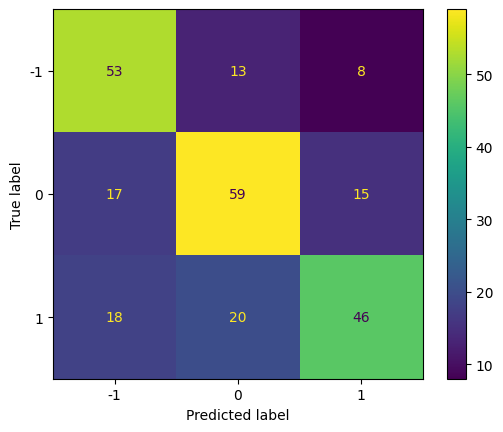

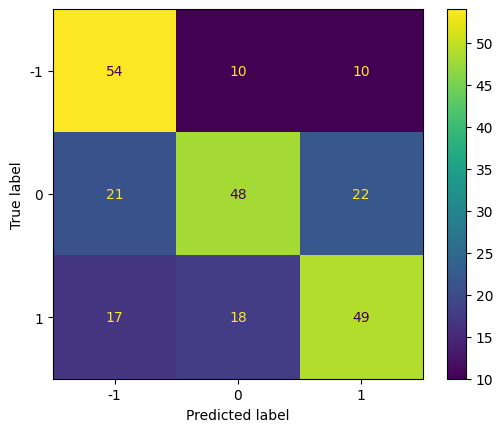

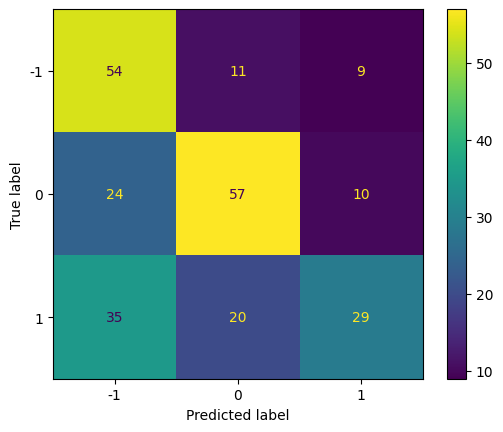

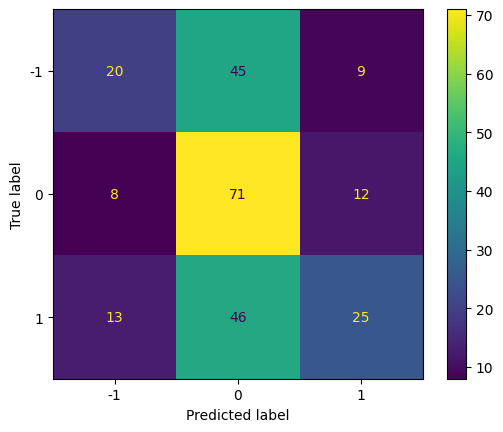

In [117]:

from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score
for i in lst:
  print(i)
  i.fit(X_train,y_train)
  y_pred=i.predict(X_test)
  s="facebook is a hub of fake information"
  y_new=i.predict(vectorizer.transform([s]))
  print("****************************Prediction for new string***************************",end=" ")
  if y_new==-1:
    print("*******Negative***************")
  elif y_new==0:
    print("*******Neutral*************")
  else:
    print('**************Positive**************')

  print(classification_report(y_test,y_pred))
  print("__________________________________________________")
  print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred))
  print("---------------------------------------------------")
  print("The Accuracy score of",i,":",accuracy_score(y_test,y_pred))

**Machine Learing model Accuracy Score**


1.   Support Vector Machine:63%

2.   Naive Bayes:60%

3.   Random Forest:56%

4.   AdoBoost:47%




